<h1>CSE483 Computer Vision Major Task</h1>
<h2>Team 1</h2>
<ul>
<li>Youssef George 19p9824</li>
<li>Kerollos Wageeh 19p3468</li>
<li>Nada Amr 19p1621</li>
</ul>

## Import libraries
Use "pip install libName" in terminal if any of them is not installed on your machine.

In [2]:
import pandas as pd
import numpy as np
import scipy
from collections import Counter
import seaborn as sns
import cv2
from sklearn import metrics
from scipy.io import loadmat
import imutils
import json


# for visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

## Discovering digitalStruct file

In [2]:
with open('SVHN/train/digitStruct.json') as f:
    data = json.load(f)
print(type(data))
print("sample data item:\n", data[0])
print("each item is of type: ", type(data[0]))
print("each item has 2 keys: ", data[0].keys())
print("each boxes is a", type(data[0]['boxes']), "of: ", len(data[0]['boxes']), type(data[0]['boxes'][0]))
print("first dict has ", data[0]['boxes'][0].keys())
print("second dict has ", data[0]['boxes'][1].keys())
for i in range(len(data)):
    data[i]['filename'] = 'train/'+data[i]['filename']

<class 'list'>
sample data item:
 {'filename': '1.png', 'boxes': [{'height': 219.0, 'label': 1.0, 'left': 246.0, 'top': 77.0, 'width': 81.0}, {'height': 219.0, 'label': 9.0, 'left': 323.0, 'top': 81.0, 'width': 96.0}]}
each item is of type:  <class 'dict'>
each item has 2 keys:  dict_keys(['filename', 'boxes'])
each boxes is a <class 'list'> of:  2 <class 'dict'>
first dict has  dict_keys(['height', 'label', 'left', 'top', 'width'])
second dict has  dict_keys(['height', 'label', 'left', 'top', 'width'])


## Import Pics with labels

In [3]:
def getPics(chosen_set):
    images = []
    labels = []
    
    picsFolder_path = "SVHN/" + chosen_set + "/"
    with open(picsFolder_path + 'digitStruct.json') as f:
        data = json.load(f)

# import colored pictures
    for i in range(len(data)):
        image = cv2.imread(picsFolder_path + data[i]['filename'])
        images.append(image)
        temp=[]
        for j in range(len(data[i]['boxes'])):
            temp.append(data[i]['boxes'][j]['label'])
        temp = np.array(temp)
        labels.append(temp)

    print("There are ", len(data), " images in " + chosen_set + " set.")
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

In [4]:
train_images, train_labels = getPics("train")

There are  33402  images in train set.


- View sample image

sample train image of lable(s):  [1. 9.]


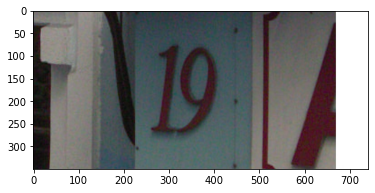

In [5]:
i = 0
print("sample train image of lable(s): ",train_labels[i] )
plt.imshow(train_images[i])
plt.show()

- Convert to grayscale

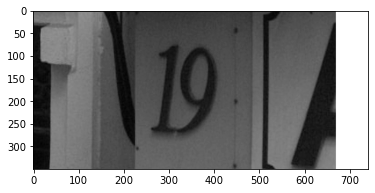

In [6]:
gray = cv2.cvtColor(train_images[i],cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
plt.show()

- Gaussian blur

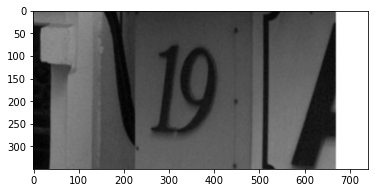

In [7]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plt.imshow(blurred, cmap='gray')
plt.show()

- Canny edge detection

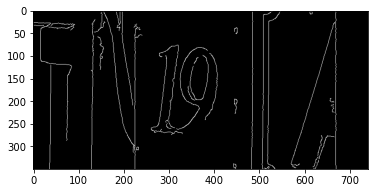

In [8]:
edged = cv2.Canny(blurred, 10, 70, 255)
plt.imshow(edged, cmap='gray')
plt.show()

- Closing then opening

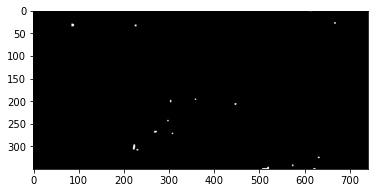

In [9]:
kernel = np.ones((3, 3), np.uint8)
closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel, iterations=1)
opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel, iterations=1)
plt.imshow(opened, cmap='gray')
plt.show()

- Finding countours

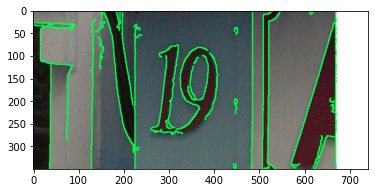

In [10]:
contours, hierarchy  = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
img = cv2.drawContours(train_images[i], contours, -1, (0,255,75), 2)
plt.imshow(img)
plt.show()

In [26]:
# find contours in the edge map, then sort them by their
# size in descending order
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
displayCnt = None
# loop over the contours
for c in cnts:
	# approximate the contour
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.02 * peri, True)
	# if the contour has four vertices, then we have found the thermostat display
	if len(approx) == 4:
		displayCnt = approx
		break


In [18]:
def getPicsCropped(chosen_set):
    images = []
    gs_images = []
    labels = []

    picsFolder_path = "SVHN/" + chosen_set + "_32x32.mat"
    data = scipy.io.loadmat(picsFolder_path)
    images = data['X']
    labels = data['y']
    images = np.array(images)
    images = np.moveaxis(images, -1, 0)
    gs_images = np.array(gs_images)
    gs_images = np.moveaxis(gs_images, -1, 0)
    labels = np.array(labels)
    print(images.shape[0],"cropped images in 32x32 " + chosen_set + " set.")
    return images, labels

cropped_train_images, cropped_train_labels = getPicsCropped("train")
print(cropped_train_images.shape)


73257 cropped images in 32x32 train set.
(73257, 32, 32, 3)


sample cropped train image of lable(s):  [2]


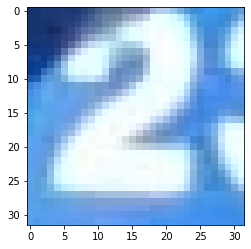

In [ ]:
i = 2
print("sample cropped train image of lable(s): ",cropped_train_labels[i] )
plt.imshow(cropped_train_images[i])
plt.show()

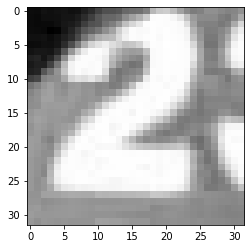

In [35]:
gray = cv2.cvtColor(cropped_train_images[i],cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
plt.show()

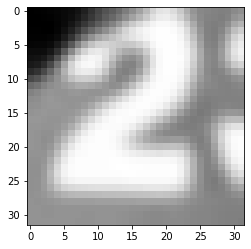

In [36]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plt.imshow(blurred, cmap='gray')
plt.show()

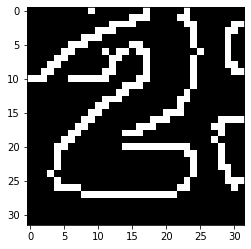

In [37]:
edged = cv2.Canny(blurred, 40, 100, 255)
plt.imshow(edged, cmap='gray')
plt.show()

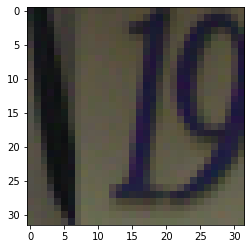

[1]


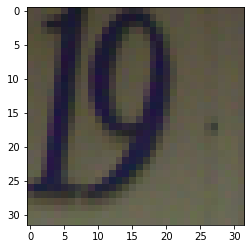

[9]


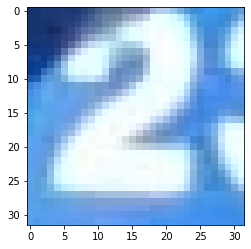

[2]


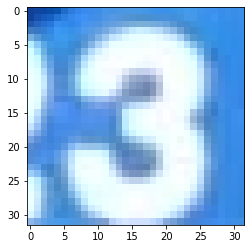

[3]


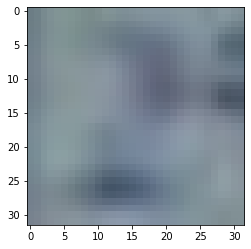

[2]


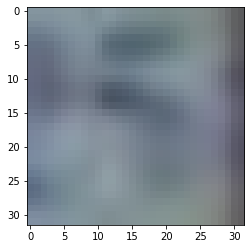

[5]


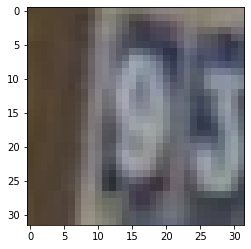

[9]


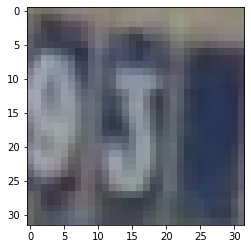

[3]


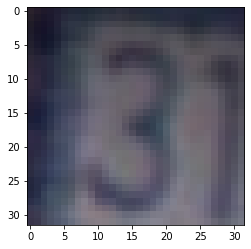

[3]


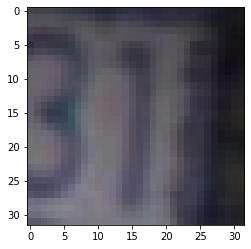

[1]


In [41]:
for i in range(10):
    plt.imshow(cropped_train_images[i, :, :, :])
    plt.show()
    print(cropped_train_labels[i])